In [7]:
import numpy as np
import pandas as pd
import matplotlib as plt
%pylab inline
# Configure plot defaults
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = '#666666'
%config InlineBackend.figure_format = 'png'
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from matplotlib import rcParams
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
X = pd.read_fwf('/content/drive/MyDrive/Sandeep_and_Harish_work/sensitivityruns/data_for_GMD/MARS_and_Sobol_data/input_parameters_MARS_Sobol.txt',header=None)
X = pd.concat([X.iloc[:,0:14],X.iloc[:,15:]],axis=1)
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23,24
0,0.0879,0.2807,0.1890,0.6511,0.2338,0.5177,0.4370,0.5888,0.0301,0.8195,0.6544,0.7529,0.2128,0.8716,0.7645,0.0646,0.5739,0.8696,0.9242,0.6375,0.6789,0.3913,0.4369,0.4186
1,0.5153,0.7686,0.6757,0.5967,0.9500,0.5352,0.0456,0.2252,0.5742,0.8978,0.6199,0.5928,0.9958,0.0723,0.8371,0.9858,0.2579,0.8629,0.5034,0.3296,0.4936,0.0931,0.8548,0.6775
2,0.3943,0.7704,0.0529,0.0090,0.0083,0.0688,0.9996,0.4619,0.7841,0.5631,0.9313,0.6107,0.0258,0.7818,0.7701,0.5131,0.8486,0.0055,0.0146,0.1163,0.5348,0.1600,0.4304,0.2770
3,0.9446,0.0434,0.1577,0.5616,0.1896,0.5129,0.3456,0.1049,0.1073,0.3080,0.0194,0.0443,0.5737,0.0143,0.6521,0.7795,0.9952,0.0839,0.9828,0.6451,0.5836,0.4598,0.1285,0.5187
4,0.2402,0.6999,0.1658,0.3759,0.7166,0.1432,0.6049,0.3403,0.9557,0.4347,0.8471,0.4167,0.2357,0.0292,0.9426,0.3507,0.9338,0.2757,0.5799,0.5207,0.4799,0.2266,0.7071,0.2558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.7200,0.3279,0.9909,0.0051,0.3415,0.6969,0.6484,0.2871,0.1547,0.4594,0.2620,0.7938,0.1909,0.8634,0.3194,0.7340,0.3326,0.8797,0.4923,0.7535,0.1244,0.9696,0.3116,0.0283
246,0.2713,0.5085,0.6870,0.3099,0.1405,0.1688,0.4549,0.9789,0.9867,0.3027,0.1342,0.3405,0.0069,0.4022,0.7018,0.0780,0.3409,0.6678,0.8736,0.1796,0.6668,0.6349,0.6454,0.5673
247,0.7647,0.8047,0.2780,0.6781,0.1725,0.6587,0.7479,0.1495,0.7002,0.0661,0.8176,0.8944,0.8777,0.1477,0.0648,0.6901,0.8032,0.5433,0.8363,0.8531,0.5051,0.0842,0.7266,0.5565
248,0.0027,0.4330,0.0732,0.0001,0.1678,0.9175,0.2974,0.6741,0.4885,0.5709,0.6826,0.5682,0.4015,0.7462,0.2264,0.5925,0.2173,0.8426,0.5501,0.6062,0.5598,0.6600,0.5111,0.5459


In [10]:
Y = pd.read_excel('/content/drive/MyDrive/Sandeep_and_Harish_work/sensitivityruns/data_for_GMD/MARS_and_Sobol_data/output_variables_MARS_Sobol_runs.xlsx',sheet_name='RMSE_variables',nrows=250,usecols = 'B:I')
Y

,WS10,SAT,SAP,RAIN,PBLH,OLR,DSWRF,DLWRF
0,2.722384,2.328833,923.620423,8.320000,388.357200,52.951052,126.561389,23.596080
1,2.332926,2.074557,919.679384,8.980714,388.174131,52.892022,143.018048,19.360958
2,3.045440,2.541654,922.728494,7.875313,389.717209,52.462319,120.150382,22.696423
3,2.868819,2.384805,921.612134,8.510566,388.918008,52.211615,148.857439,21.381934
4,2.673051,2.243006,919.469351,7.924683,382.371321,51.936048,140.067615,20.100543
...,...,...,...,...,...,...,...,...
245,2.271949,2.308478,925.976314,8.201370,385.797599,54.516736,121.394565,23.346654
246,2.315647,2.079771,922.183060,8.144154,374.233830,54.454176,126.689549,20.618247
247,2.572847,2.254726,922.197317,8.628788,399.124852,61.342643,130.509279,21.368687
248,2.972289,2.249624,924.608892,8.566329,387.909723,54.808774,122.192953,22.957464


In [11]:
Y=(Y-Y.min())/(Y.max()-Y.min())

In [12]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF, DotProduct, ExpSineSquared, RationalQuadratic
GPR_score = np.zeros((10,8))
Y_PRED = np.zeros((250,8))
Y_TRUE = np.zeros((250,8))
for i in range(8):
  kernel = ConstantKernel()+ 1.0**2 * RBF(length_scale=np.ones((24,1))) + WhiteKernel(noise_level=1e-10)
  model = gaussian_process.GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=10)
  y_pred = np.zeros(1)
  y_true = np.zeros(1)
  for k in range(10):
    X_train = pd.concat([X.iloc[0:k*25,:],X.iloc[(k+1)*25:,:]],axis=0)
    X_test = X.iloc[k*25:(k+1)*25,:]
    y_train = pd.concat([Y.iloc[0:k*25,i],Y.iloc[(k+1)*25:,i]],axis=0)
    y_test = Y.iloc[k*25:(k+1)*25,i]
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    GPR_score[k,i] = r2_score(y_test,y_hat)
    y_pred = np.append(y_pred,y_hat,axis=0)
    y_true = np.append(y_true,y_test,axis=0)
  Y_PRED[:,i] = y_pred[1:]
  Y_TRUE[:,i] = y_true[1:]
  y_pred = pd.DataFrame(y_pred[1:])
  y_true = pd.DataFrame(y_true[1:])
  print(Y.columns[i],r2_score(y_true,y_pred))


WS10 0.9969189546005162
SAT 0.9906027510042079
SAP 0.8822554858940354
RAIN 0.9781945947233637
PBLH 0.9578061984364945
OLR 0.9717690084503674
DSWRF 0.9867842938486618
DLWRF 0.9851237979429772


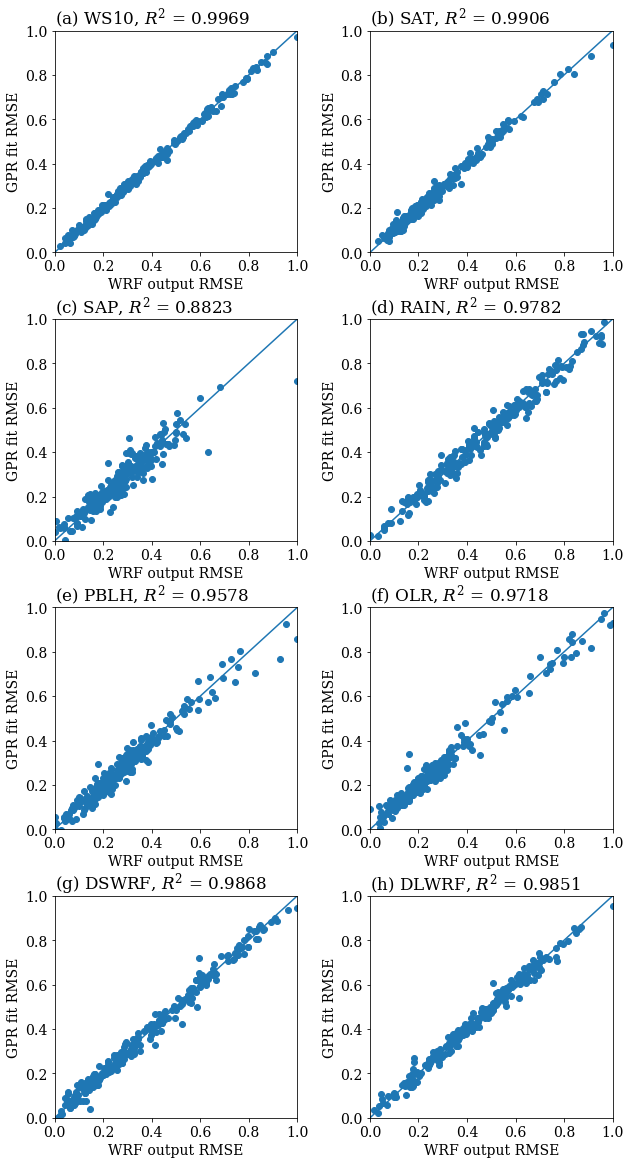

In [13]:
fig = plt.figure(figsize=(10,20))
plt.rc('font', size=14)    # fontsize of the all text
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('xtick', labelsize=14)
abc = ['(a) ','(b) ','(c) ','(d) ','(e) ','(f) ','(g) ','(h) '] 
for i in range(8):
  ax = fig.add_subplot(4,2,i+1)
  ax.plot([0,1])
  ax.scatter(Y_TRUE[:,i],Y_PRED[:,i])
  ax.set_title(abc[i]+Y.columns[i]+', $R^2$ = '+str(round(r2_score(Y_TRUE[:,i],Y_PRED[:,i]),4)),loc='left')
  ax.set_xlabel('WRF output RMSE')
  ax.set_ylabel('GPR fit RMSE')
  ax.set_xlim(0,1)
  ax.set_ylim(0,1)
plt.subplots_adjust(wspace=0.3,hspace=0.3)
plt.savefig('/content/drive/MyDrive/Sandeep_and_Harish_work/sensitivityruns/data_for_GMD/MARS_and_Sobol_data/GPR_accuracy.pdf',dpi=1200,bbox_inches='tight',pad_inches=0.1)

Support Vector Regression

In [14]:
from sklearn.svm import SVR
SVM_score = np.zeros((10,8))
for i in range(8):
#  kernel =  ConstantKernel() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1e-10)
  model = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1) 
  y_pred = np.zeros(1)
  y_true = np.zeros(1)
  for k in range(10):
    X_train = pd.concat([X.iloc[0:k*25,:],X.iloc[(k+1)*25:,:]],axis=0)
    X_test = X.iloc[k*25:(k+1)*25,:]
    y_train = pd.concat([Y.iloc[0:k*25,i],Y.iloc[(k+1)*25:,i]],axis=0)
    y_test = Y.iloc[k*25:(k+1)*25,i]
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    SVM_score[k,i] = r2_score(y_test,y_hat)
    y_pred = np.append(y_pred,y_hat,axis=0)
    y_true = np.append(y_true,y_test,axis=0)
  y_pred = pd.DataFrame(y_pred[1:])
  y_true = pd.DataFrame(y_true[1:])
  print(Y.columns[i],r2_score(y_true,y_pred))

WS10 0.8942589181723868
SAT 0.7719265110595714
SAP 0.4886642769415056
RAIN 0.9170261434813247
PBLH 0.4785018757464935
OLR 0.4147328494861524
DSWRF 0.876004093934758
DLWRF 0.8719087921400575


Random forest regression

In [15]:
from sklearn.ensemble import RandomForestRegressor
RF_score = np.zeros((10,8))
for i in range(8):
#  kernel =  ConstantKernel() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1e-10)
  model = RandomForestRegressor() 
  y_pred = np.zeros(1)
  y_true = np.zeros(1)
  for k in range(10):
    X_train = pd.concat([X.iloc[0:k*25,:],X.iloc[(k+1)*25:,:]],axis=0)
    X_test = X.iloc[k*25:(k+1)*25,:]
    y_train = pd.concat([Y.iloc[0:k*25,i],Y.iloc[(k+1)*25:,i]],axis=0)
    y_test = Y.iloc[k*25:(k+1)*25,i]
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    RF_score[k,i] = r2_score(y_test,y_hat)
    y_pred = np.append(y_pred,y_hat,axis=0)
    y_true = np.append(y_true,y_test,axis=0)
  y_pred = pd.DataFrame(y_pred[1:])
  y_true = pd.DataFrame(y_true[1:])
  print(Y.columns[i],r2_score(y_true,y_pred))

WS10 0.8964139726029368
SAT 0.88565801954899
SAP 0.5967571620427827
RAIN 0.8521214448303438
PBLH 0.6141613647112678
OLR 0.9114576272971264
DSWRF 0.9087585565939436
DLWRF 0.7527581699635165


Regression Tree

In [16]:
from sklearn.tree import DecisionTreeRegressor
RT_score = np.zeros((10,8))
for i in range(8):
  model = DecisionTreeRegressor() 
  y_pred = np.zeros(1)
  y_true = np.zeros(1)
  for k in range(10):
    X_train = pd.concat([X.iloc[0:k*25,:],X.iloc[(k+1)*25:,:]],axis=0)
    X_test = X.iloc[k*25:(k+1)*25,:]
    y_train = pd.concat([Y.iloc[0:k*25,i],Y.iloc[(k+1)*25:,i]],axis=0)
    y_test = Y.iloc[k*25:(k+1)*25,i]
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    RT_score[k,i] = r2_score(y_test,y_hat)
    y_pred = np.append(y_pred,y_hat,axis=0)
    y_true = np.append(y_true,y_test,axis=0)
  y_pred = pd.DataFrame(y_pred[1:])
  y_true = pd.DataFrame(y_true[1:])
  print(Y.columns[i],r2_score(y_true,y_pred))

WS10 0.7472750320033303
SAT 0.7679100245540651
SAP 0.2927846878069751
RAIN 0.6759447519362825
PBLH 0.2527720900651881
OLR 0.8613615867646984
DSWRF 0.8210523200356596
DLWRF 0.506293891292577


K Nearst Neighborhood Regression

In [17]:
from sklearn.neighbors import KNeighborsRegressor
KNN_score = np.zeros((10,8))
for i in range(8):
  model = KNeighborsRegressor() 
  y_pred = np.zeros(1)
  y_true = np.zeros(1)
  for k in range(10):
    X_train = pd.concat([X.iloc[0:k*25,:],X.iloc[(k+1)*25:,:]],axis=0)
    X_test = X.iloc[k*25:(k+1)*25,:]
    y_train = pd.concat([Y.iloc[0:k*25,i],Y.iloc[(k+1)*25:,i]],axis=0)
    y_test = Y.iloc[k*25:(k+1)*25,i]
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    KNN_score[k,i] = r2_score(y_test,y_hat)
    y_pred = np.append(y_pred,y_hat,axis=0)
    y_true = np.append(y_true,y_test,axis=0)
  y_pred = pd.DataFrame(y_pred[1:])
  y_true = pd.DataFrame(y_true[1:])
  print(Y.columns[i],r2_score(y_true,y_pred))

WS10 0.4958902549700003
SAT 0.4633515132574513
SAP 0.32787386989958944
RAIN 0.4920416906503139
PBLH 0.18349534544658586
OLR 0.23504404674252855
DSWRF 0.49756229557709897
DLWRF 0.4880220263416709


In [18]:
RT_score.shape

(10, 8)

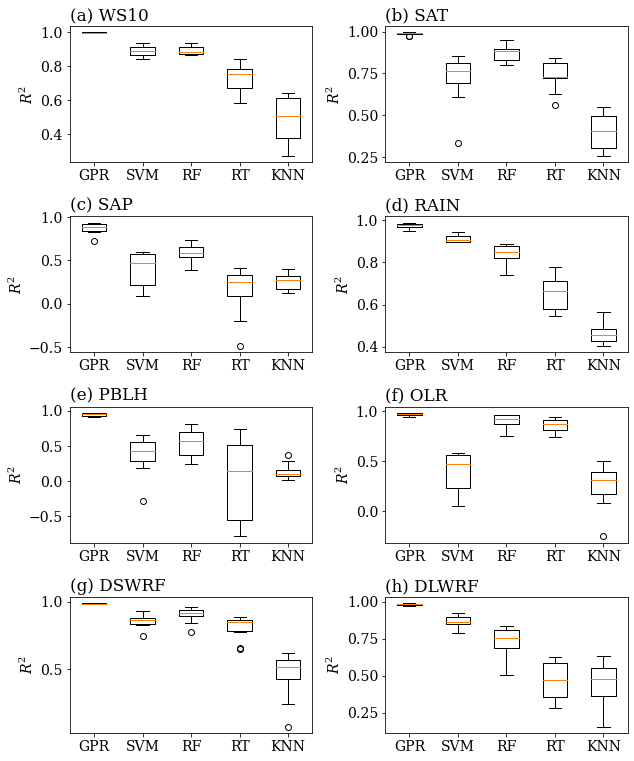

In [19]:
fig = plt.figure(figsize=(10,13))
plt.rc('font', size=14)    # fontsize of the all text
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('xtick', labelsize=14)
abc = ['(a) ','(b) ','(c) ','(d) ','(e) ','(f) ','(g) ','(h) '] 
for i in range(8):
  DMY = [GPR_score[:,i],SVM_score[:,i],RF_score[:,i],RT_score[:,i],KNN_score[:,i]]
  axs = fig.add_subplot(4,2,i+1)
  axs.boxplot(DMY)
  axs.set_title(abc[i]+Y.columns[i],loc='left')
  axs.set_ylabel('$R^2$')
  axs.set_xticklabels(['GPR','SVM','RF','RT','KNN'])
plt.subplots_adjust(wspace=0.3,hspace=0.4)
plt.savefig('/content/drive/MyDrive/Sandeep_and_Harish_work/sensitivityruns/data_for_GMD/MARS_and_Sobol_data/surrogate_models_boxplot.pdf',dpi=1200,bbox_inches='tight',pad_inches=0.1)

GPR sensitivity to the number of samples

In [20]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF, DotProduct, ExpSineSquared, RationalQuadratic
kernel = ConstantKernel()+ 1.0**2 * RBF(length_scale=np.ones((24,1))) + WhiteKernel(noise_level=1e-10)
model = gaussian_process.GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=10)
GPR_score = np.zeros((8,5,5))
N = [50,100,150,200,250]
for i in range(8):
  for j in range(5):
    n = int(N[j]/5)
    y_pred = np.zeros(1)
    y_true = np.zeros(1)
    for k in range(5):
      X_train = pd.concat([X.iloc[0:k*n,:],X.iloc[(k+1)*n:N[j],:]],axis=0)
      X_test = X.iloc[k*n:(k+1)*n,:]
      y_train = pd.concat([Y.iloc[0:k*n,i],Y.iloc[(k+1)*n:N[j],i]],axis=0)
      y_test = Y.iloc[k*n:(k+1)*n,i]
      model.fit(X_train, y_train)
      y_hat = model.predict(X_test)
      GPR_score[i,j,k] = r2_score(y_test,y_hat)
      y_pred = np.append(y_pred,y_hat,axis=0)
      y_true = np.append(y_true,y_test,axis=0)
    y_pred = pd.DataFrame(y_pred[1:])
    y_true = pd.DataFrame(y_true[1:])
    print(Y.columns[i],'N=',N[j],r2_score(y_true,y_pred))

WS10 N= 50 0.9565437855027383
WS10 N= 100 0.987138204147253
WS10 N= 150 0.9904368820888584
WS10 N= 200 0.9953812971668702
WS10 N= 250 0.9971446469460513
SAT N= 50 0.8518136786442589
SAT N= 100 0.9746416509245199
SAT N= 150 0.9837400202600026
SAT N= 200 0.9849945671021403
SAT N= 250 0.9887202228581741
SAP N= 50 -0.002950709993697398
SAP N= 100 0.5850515518414177
SAP N= 150 0.7437552621328609
SAP N= 200 0.8402278672193862
SAP N= 250 0.883510403350331
RAIN N= 50 0.8783705199437113
RAIN N= 100 0.9489573231284003
RAIN N= 150 0.9600977619473644
RAIN N= 200 0.9757454799622424
RAIN N= 250 0.9790847732990834
PBLH N= 50 0.36444996310585887
PBLH N= 100 0.8926206100433344
PBLH N= 150 0.9432055072191486
PBLH N= 200 0.9531214841830942
PBLH N= 250 0.9390470725306442
OLR N= 50 0.6580683053392424
OLR N= 100 0.914055629596595
OLR N= 150 0.9326773291393234
OLR N= 200 0.96526468424073
OLR N= 250 0.9713667951002772
DSWRF N= 50 0.8125828117660838
DSWRF N= 100 0.9388556993969974
DSWRF N= 150 0.96364718055139

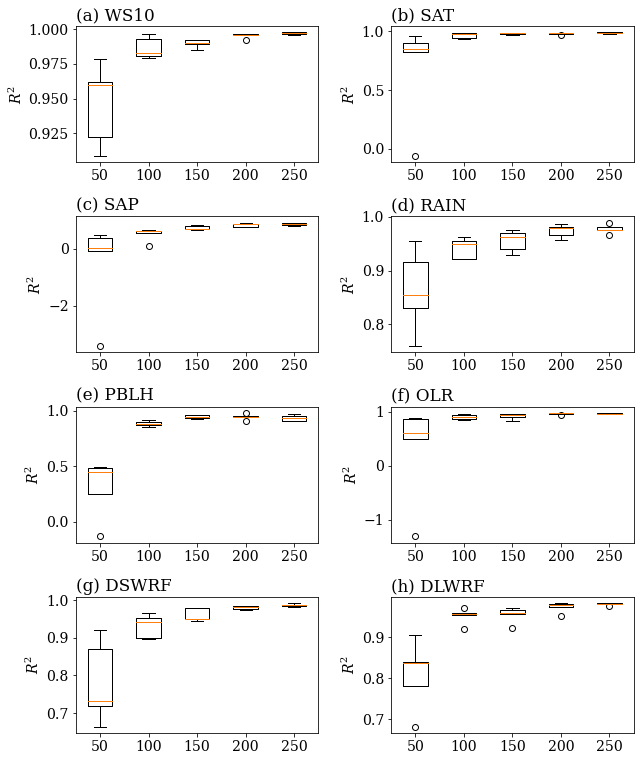

In [25]:
fig = plt.figure(figsize=(10,13))
plt.rc('font', size=14)    # fontsize of the all text
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('xtick', labelsize=14) 
abc = ['(a) ','(b) ','(c) ','(d) ','(e) ','(f) ','(g) ','(h) ']
for i in range(8):
  axs = fig.add_subplot(4,2,i+1)
  axs.boxplot(GPR_score[i,:,:].T)
  axs.set_title(abc[i]+Y.columns[i],loc='left')
  axs.set_ylabel('$R^2$')
  axs.set_xticklabels(['50','100','150','200','250'])
plt.subplots_adjust(wspace=0.3,hspace=0.4)
plt.savefig('/content/drive/MyDrive/Sandeep_and_Harish_work/sensitivityruns/data_for_GMD/MARS_and_Sobol_data/GPR_sensitivity_boxplot.pdf',dpi=1200,bbox_inches='tight',pad_inches=0.1)